In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('../..')
import BOPackage

In [15]:
def Ackley(X):
        n = X.shape[1]  # Number of dimensions (should be 20 for this problem)

        # Calculate the objective function value for each row in X
        term1 = -20 * np.exp(-0.2 * np.sqrt(np.sum(X**2, axis=1) / n))
        term2 = -np.exp(np.sum(np.cos(2 * np.pi * X), axis=1) / n)
        y = term1 + term2 + 20 + np.e

        # Make function negative to find the minimum
        y = -y.reshape(-1, 1)

        return y

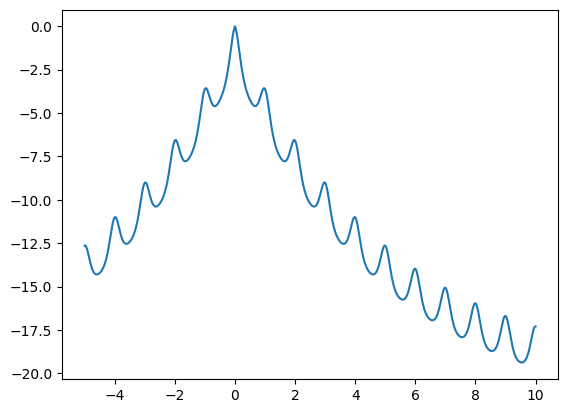

In [16]:
bounds = np.array([[-5, 10]] * 1)

candidate_x = np.linspace(bounds[0,0], bounds[0,1], 1001, endpoint=True).reshape(1001, 1)

result = Ackley(candidate_x)

# Plot the contour
plot = plt.plot(candidate_x, result)

In [4]:
def PriorMeanFunction(X):
    return - np.ones(len(X)).reshape(len(X), 1)

In [5]:
def RunBenchmark(dimensions, length_scale, kappa, acquisition_samples, iterations, images=False):
    bounds = np.array([[-5, 10]] * dimensions)
    ObjectiveFunction = Ackley

    """
    Standard configuration (no batches, no sub-batches, no bounds reduction)
    """
    PriorMean = PriorMeanFunction
    Kernel = BOPackage.RBF_Kernel_GPU
    AcquisitionFunction = BOPackage.UpperConfidenceBound

    random_seed = int(np.random.random() * 1000)

    # Create the object
    bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                      KernelFunction=Kernel, 
                      length_scale=length_scale, 
                      bounds=bounds, 
                      AcquisitionFunction=AcquisitionFunction, 
                      acquisition_samples=acquisition_samples,
                      random_seed=random_seed)

    raw_X = bo.GetRandomXBatch(1)
    raw_y = ObjectiveFunction(raw_X)
    bo.UpdateData(raw_X, raw_y)

    for i in range(iterations):
        raw_X = bo.GetNextX(kappa=kappa)
        raw_y = ObjectiveFunction(np.array(raw_X))
        bo.UpdateData(raw_X, raw_y)

    if images:
        BOPackage.PlotData(bo)

    return random_seed, np.max(bo.y_data[0:25]), np.max(bo.y_data[0:50]), np.max(bo.y_data[0:])

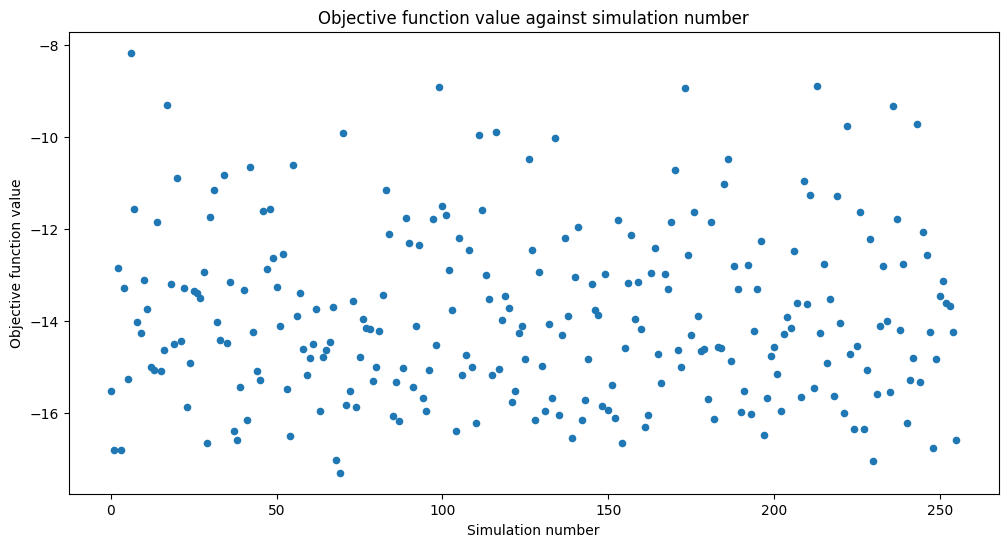

In [6]:
length_scales = np.array([[7], [7], [7], [7], [7], [7]])
min_kappa = 0.1
max_kappa = 100
iterations = 100
dimensions = 6
acquisition_samples = 6**dimensions
batch_size = 32
sub_batch_size = 4

bounds = np.array([[-5, 10]] * dimensions)

PriorMean = PriorMeanFunction
Kernel = BOPackage.RBF_Kernel_GPU
AcquisitionFunction = BOPackage.UpperConfidenceBound

random_seed = int(np.random.random() * 1000)

bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scales, 
                  bounds=bounds, 
                  AcquisitionFunction=AcquisitionFunction, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed)

raw_X = bo.GetRandomXBatch(256)
raw_y = Ackley(raw_X)
bo.UpdateData(raw_X, raw_y)

BOPackage.PlotData(bo, legend=False)

In [7]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[7], [7], [7], [7], [7], [7]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

2025-04-01 10:53:47.946632: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-04-01 10:53:47.946661: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-01 10:53:47.946691: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-01 10:53:47.946753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-01 10:53:47.946772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Optimal parameters: [[7.7291821 ]
 [8.09772869]
 [7.2193916 ]
 [5.05313499]
 [7.31459947]
 [7.29711256]]
Function value at optimum: 2850.077592656545
Converged: True
Number of iterations: 12
Number of function evaluations: 112


0
1
2
3
4
5
6
7
8
9


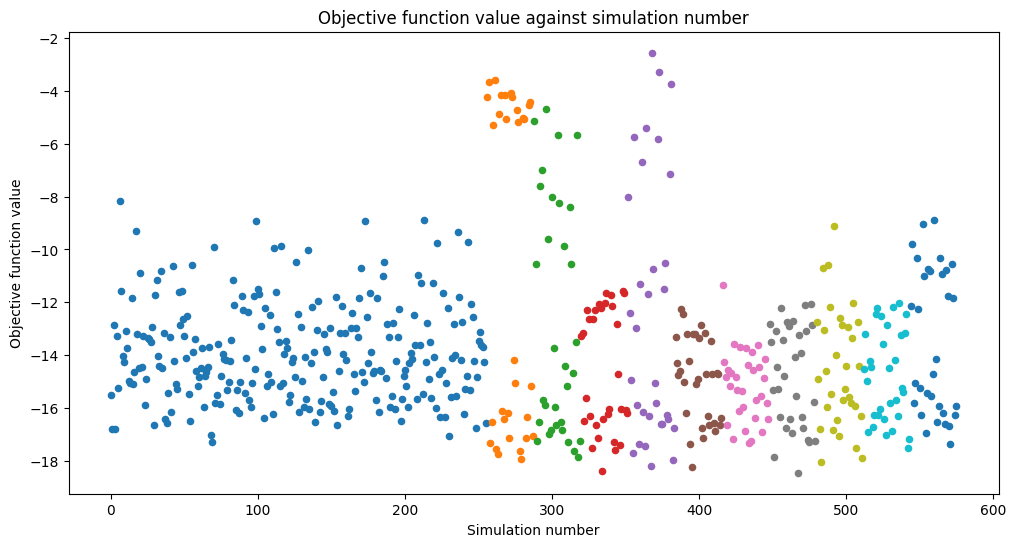

In [8]:
for i in range(10):
    print(i)
    raw_X = bo.GetNextXBatch(batch_size, sub_batch_size=sub_batch_size, min_kappa=min_kappa, max_kappa=max_kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

BOPackage.PlotData(bo, legend=False)

In [9]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[1], [1], [1], [1], [1], [1]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[ 5.95956085]
 [ 8.03217208]
 [ 2.43791556]
 [ 1.64706999]
 [ 8.45246665]
 [13.52607657]]
Function value at optimum: 13707.077654583556
Converged: True
Number of iterations: 18
Number of function evaluations: 168


0
1
2
3
4
5
6
7
8
9


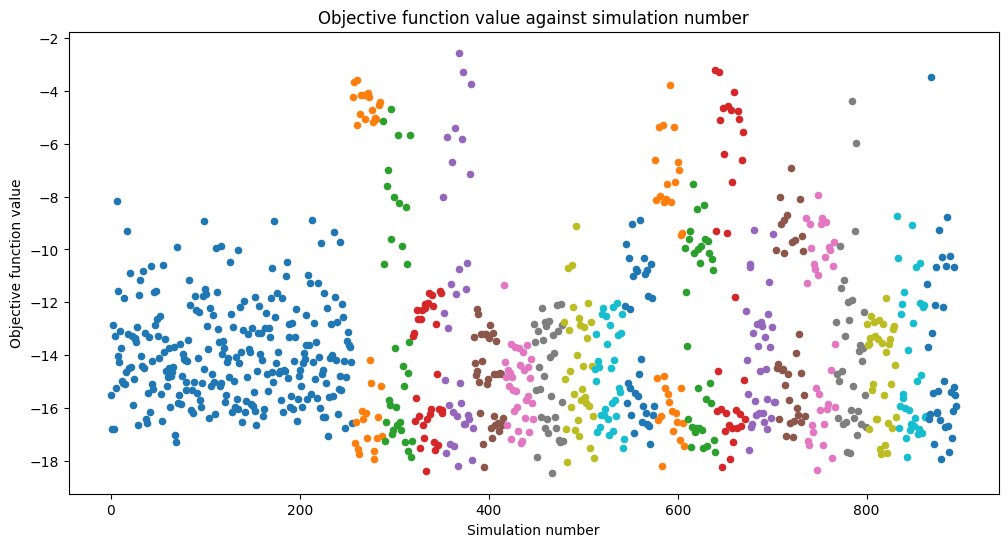

In [10]:
for i in range(10):
    print(i)
    raw_X = bo.GetNextXBatch(batch_size, sub_batch_size=sub_batch_size, min_kappa=min_kappa, max_kappa=max_kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

BOPackage.PlotData(bo, legend=False)

In [11]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[1], [1], [1], [1], [1], [1]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[8.11935489]
 [2.33720458]
 [6.72838571]
 [7.4396294 ]
 [1.17079662]
 [5.80267746]]
Function value at optimum: 21376.376454812984
Converged: True
Number of iterations: 20
Number of function evaluations: 231


0
1
2
3
4
5
6
7
8
9


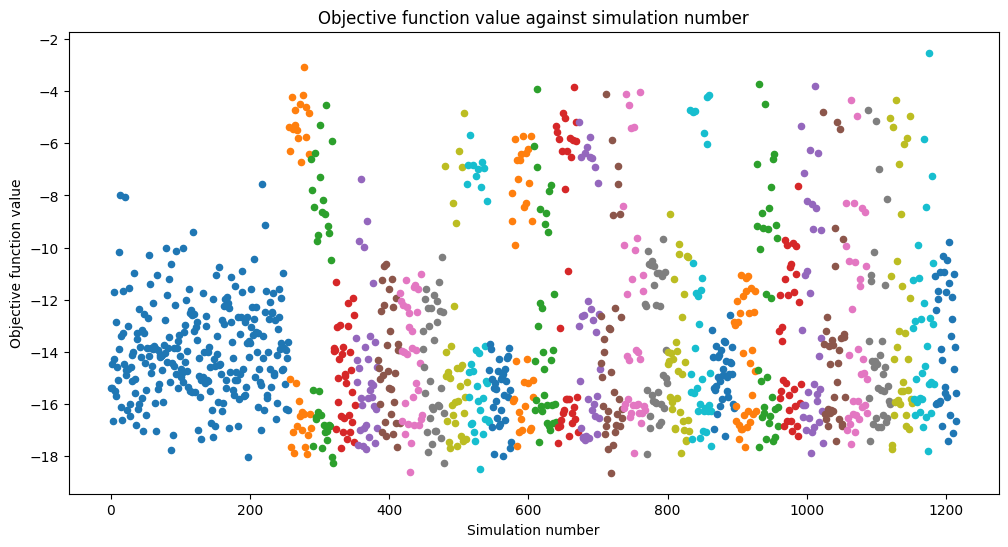

In [ ]:
for i in range(10):
    print(i)
    raw_X = bo.GetNextXBatch(batch_size, sub_batch_size=sub_batch_size, min_kappa=min_kappa, max_kappa=max_kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

BOPackage.PlotData(bo, legend=False)

In [12]:
seeds = []
firsts = []
seconds = []
thirds = []

for i in range(1):
    seed, first, second, third = RunBenchmark(dimensions, length_scale=length_scale, kappa=1, acquisition_samples=acquisition_samples, iterations=iterations)
    firsts.append(first)
    seconds.append(second)
    thirds.append(third)
    seeds.append(seed)

np.mean(firsts), np.mean(seconds), np.mean(thirds)

NameError: name 'length_scale' is not defined

0
1
2
3
4
5
6
7
8
9


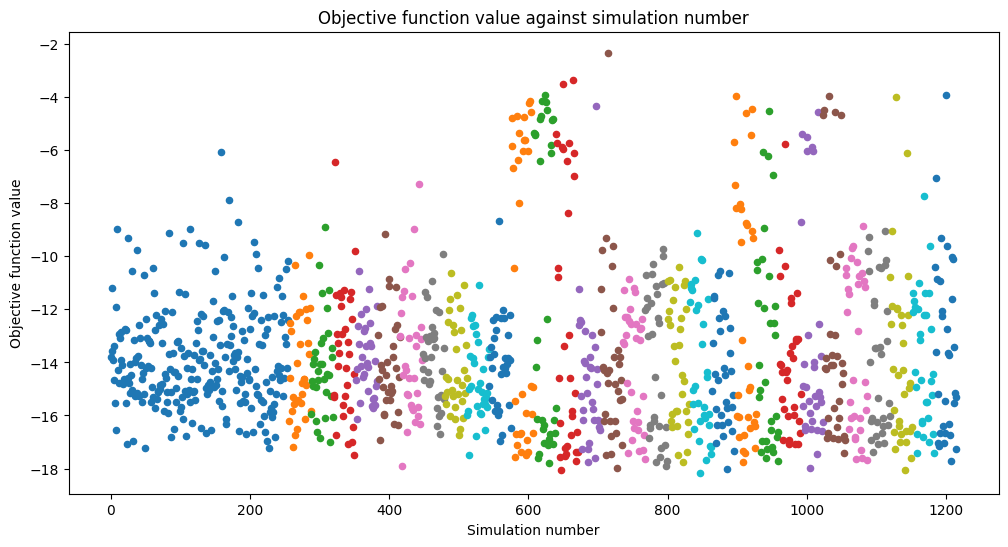

In [ ]:
for i in range(10):
    print(i)
    raw_X = bo.GetNextXBatch(batch_size, sub_batch_size=sub_batch_size, min_kappa=min_kappa, max_kappa=max_kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

BOPackage.PlotData(bo, legend=False)

In [ ]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[1], [1], [1], [1], [1], [1]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[1.20446275]
 [3.62898326]
 [8.3217526 ]
 [4.36671903]
 [3.74279537]
 [9.98156325]]
Function value at optimum: 24550.180065912497
Converged: True
Number of iterations: 20
Number of function evaluations: 231


In [ ]:
"""
1D example of what the code is doing in multiple dimensions.
"""

'\n1D example of what the code is doing in multiple dimensions.\n'

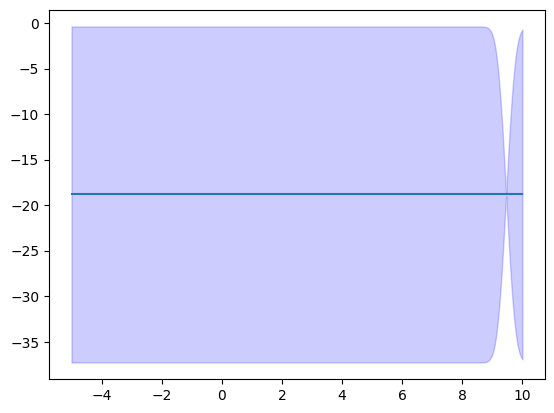

In [31]:
length_scale = 7
kappa=5
iterations = 100
dimensions = 1
acquisition_samples = 5**dimensions
batch_size = 32
sub_batch_size = 8

bounds = np.array([[-5, 10]] * dimensions)

Kernel = BOPackage.RBF_Kernel_GPU
AcquisitionFunction = BOPackage.UpperConfidenceBound

random_seed = int(np.random.random() * 1000)

bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                KernelFunction=Kernel, 
                length_scale=length_scale, 
                bounds=bounds, 
                AcquisitionFunction=AcquisitionFunction, 
                acquisition_samples=acquisition_samples,
                random_seed=random_seed)

raw_X = bo.GetRandomXBatch(1)
raw_y = Ackley(raw_X)
bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

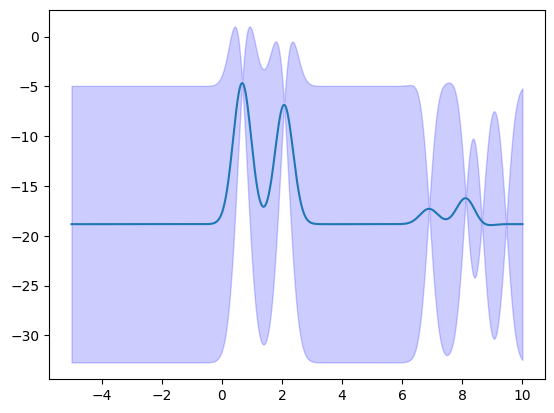

In [32]:
for i in range(5):
    raw_X = bo.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

In [33]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[1]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[1.06424695]]
Function value at optimum: 353.19978076421813
Converged: True
Number of iterations: 4
Number of function evaluations: 14


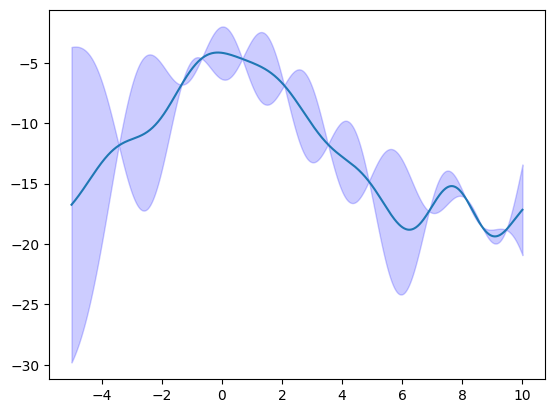

In [34]:
for i in range(5):
    raw_X = bo.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

In [35]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[1]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[1.23116629]]
Function value at optimum: 498.7377178831012
Converged: True
Number of iterations: 5
Number of function evaluations: 16


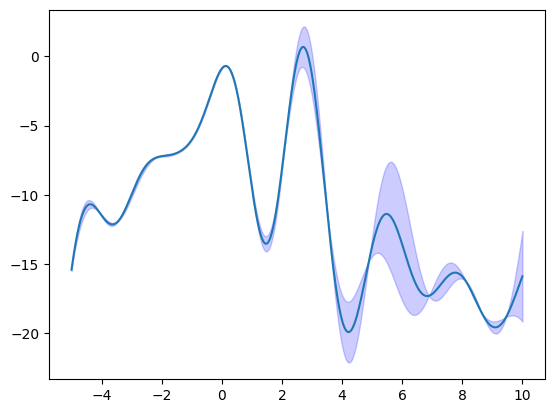

In [36]:
for i in range(5):
    raw_X = bo.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')

In [37]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[5]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[0.75908676]]
Function value at optimum: 783.1740757483575
Converged: True
Number of iterations: 6
Number of function evaluations: 90


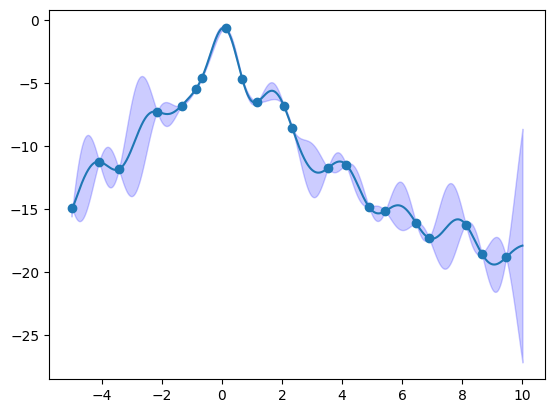

In [38]:
for i in range(5):
    raw_X = bo.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')
plt.scatter(bo.X_data, bo.y_data)

In [40]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[5]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[0.03370123]]
Function value at optimum: 1551.5003618117844
Converged: True
Number of iterations: 2
Number of function evaluations: 50


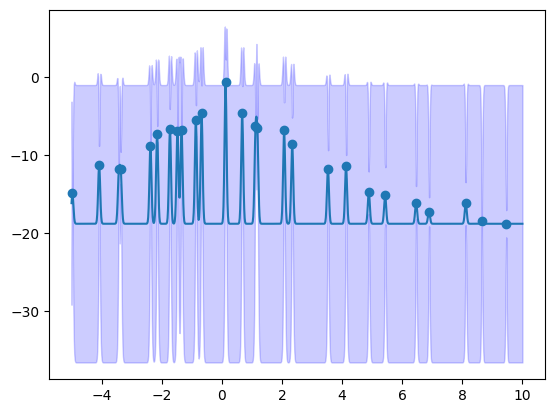

In [41]:
for i in range(5):
    raw_X = bo.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')
plt.scatter(bo.X_data, bo.y_data)

In [42]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[5]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[0.58637652]]
Function value at optimum: 945.2937506778931
Converged: True
Number of iterations: 7
Number of function evaluations: 44


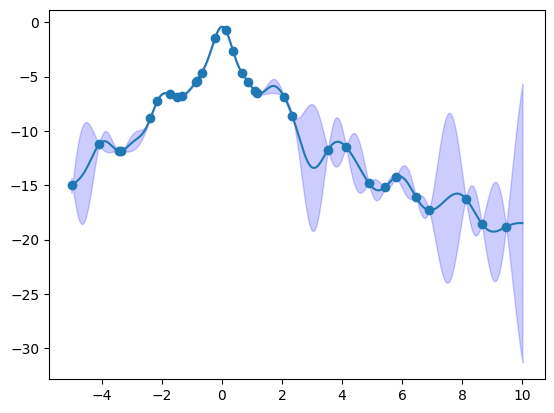

In [43]:
for i in range(5):
    raw_X = bo.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')
plt.scatter(bo.X_data, bo.y_data)

In [45]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

j = 0 

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[5]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)

bo.length_scale = optimal_params

Optimal parameters: [[0.44725054]]
Function value at optimum: 1120.8110993653759
Converged: True
Number of iterations: 6
Number of function evaluations: 40


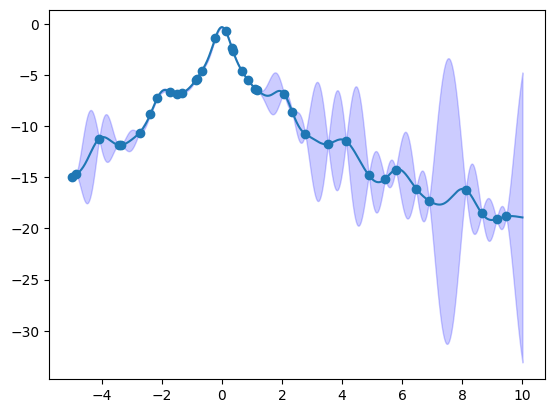

In [46]:
for i in range(5):
    raw_X = bo.GetNextX(kappa=kappa)
    raw_y = Ackley(np.array(raw_X))
    bo.UpdateData(raw_X, raw_y)

mean, variance = bo.PredictMeanVariance(candidate_x, normalised=False)

plt.plot(candidate_x, mean)
plt.fill_between(candidate_x[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'blue', alpha=0.2, label = '95% confidence interval')
plt.scatter(bo.X_data, bo.y_data)

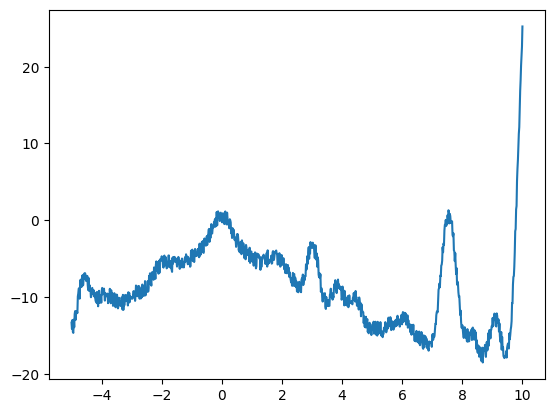

In [44]:
plt.plot(candidate_x, bo.AcquisitionFunction(mean, variance, kappa=1))

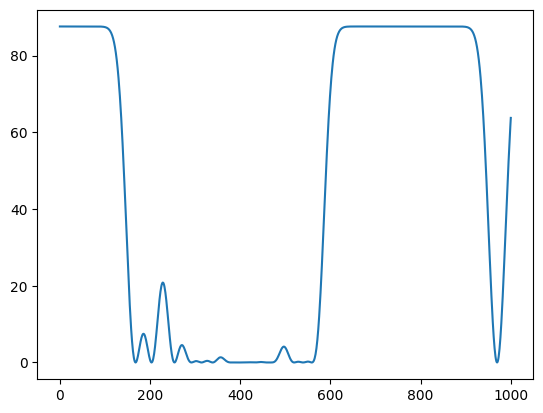

In [ ]:
plt.plot(variance)

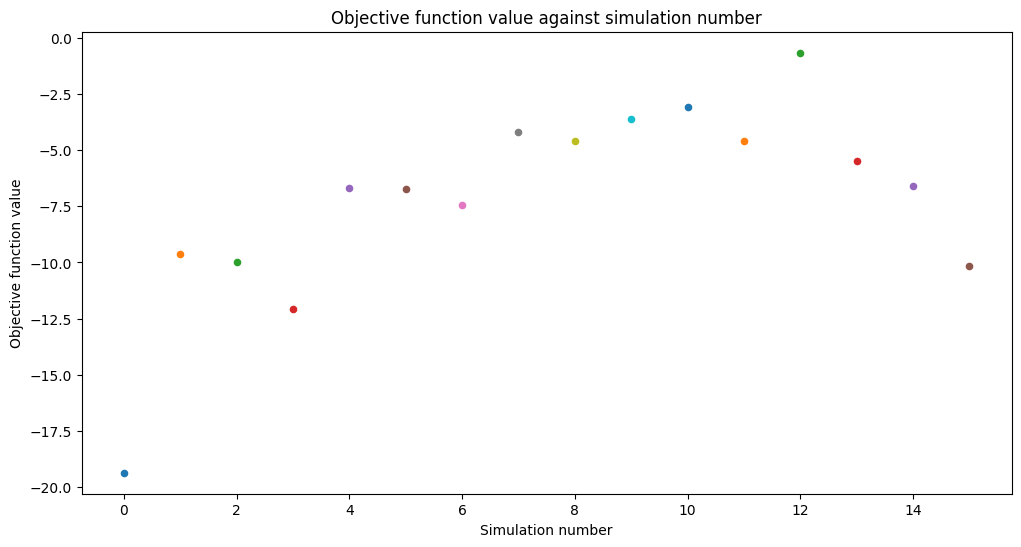

In [ ]:
BOPackage.PlotData(bo, legend=False)

In [ ]:
import numpy as np
from scipy.optimize import minimize

Kernel = BOPackage.RBF_Kernel_GPU

def objective(log_params):
    """Objective function that optimizes in log-space"""
    params = np.exp(log_params)  # Convert back to normal scale
    params = np.array(params.reshape(-1, 1))  # Reshape to column vector [[x], [y]]
    return -BOPackage.log_marginal_likelihood(bo.X_data, bo.y_data, Kernel, params)

# Initial parameters as a column vector
initial_params = np.array([[0.1], [0.2]])

# Convert to log-space and flatten to 1D array for optimization
initial_log_params = np.log(initial_params.flatten())

# Run gradient descent using L-BFGS-B
result = minimize(objective, initial_log_params, method='L-BFGS-B')

# Convert back to normal scale and reshape as column vector
optimal_params = np.exp(result.x).reshape(-1, 1)

# Print results
print("Optimal parameters:", optimal_params)
print("Function value at optimum:", result.fun)
print("Converged:", result.success)
print("Number of iterations:", result.nit)
print("Number of function evaluations:", result.nfev)